# Panic selling simulation
## Experiment Questions
- Can we simulate the death spiral of panic selling (selling -> more price drop -> more selling -> drain the liquidity pool in the end)?
- If panic selling happens, does RBS make a difference? What are the effects of different levels of RBS parameters?

## Experiment Design
- The behavior of panic selling: 
   - There will be conditional selling for the system which means that at each timestep, there is the possibility that for any reason some participants might sell if the price drop reaches certain level.
    - More formally, there will be a distribution $\Delta P$ of the price change at which a sell will occur, and a distribution N for the size of the sell at that epoch if the price change is at certain magnitude. 
- We expect to see:
    - If the RBS is stabilizing enough, the panic selling should subside and the system will get back to equilibrium. We will explore different parameters to see when that could happen and when there could be a death spiral of selling.

## Parameter Sweep

The following will be the different parameter sweep variables to test:
1. The panic sell parameters to determine the magnitude of sell amount
2. Parameterization of the RBS

### KPIs

1. Number of the pool being drained.
2. Ending price.
3. RBS interventions: The number of times the RBS had to intervene ("bid") to stabilize as well as the total amount.
4. Reserves used: The amount of reserves used by the RBS


## first, show the panic sell distribution

Text(0, 0.5, 'ohm sell amount')

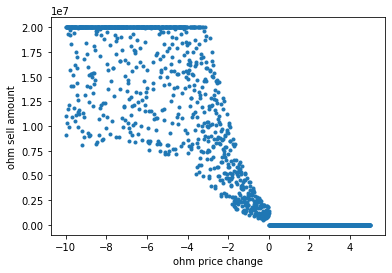

In [1]:
import numpy as np
def panic_sell_amount(price_change,liq_ohm,L=2,k=1,p0=3):
    # given the price change, how much sell will happen. right now it's governed by a logistic function
    # L is the scaling magnitude controller, ranging (0,+inf). higher L => higher ceiling
    # k is the factor adjusting the curve shape, ranging (0,+inf). bigger k => sharper increase of the sell amount
    # p0 is the turning point when the sell amount increases the fastest

    # TODO: in the future, allow different shapes of this curve 
    if price_change>=0:
        return 0
    else:
        max_amount = liq_ohm*(L/(1+np.exp(-k*(np.abs(price_change)-p0)))) # the max amount of sell given the price change is determined by a logistic function
        # turn it into a uniform distribution for each instance to introduce more randomness
        randamount = (np.random.rand()*.8+.2)*max_amount # ranging between 0.2 to 1 times of the max_amount
        if randamount > liq_ohm:
            randamount = liq_ohm
        return randamount
price_change_arr = np.arange(-10,5,.01)
amount_arr = [panic_sell_amount(p,2e7) for p in price_change_arr]
from matplotlib import pyplot as plt
plt.plot(price_change_arr,amount_arr,'.')
plt.xlabel('ohm price change')
plt.ylabel('ohm panic sell amount')

When there's price drop, the more negative it is, the bigger amount of panic sell there would be.

When there's no price drop, no panic sell.

# Run the simulation of panic sell: examples of death spirals of panic selling

In [1]:
from model.utility.default_parameters import default_params1 as params
import pandas as pd
from model.signals.bond_signals import total_value_bond_creation
number_runs = 6
number_steps = 100


#params.update({'panic_sell_on':[True,False]})
params.update({'panic_sell_on':[True]})
panic_params = [1,2,3]
params.update({'panic_param':panic_params})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run,new_run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
df1 = post_processing(raw)
df1.to_pickle('simudata/panic_sell_research/df1_panic_sell_examples.p')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 18, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 18, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 72.19s


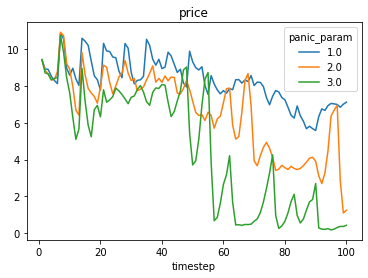

In [3]:
# Plot the average values for natural price by the groups of supply and demand factor
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

variables_to_plot = [ "price"]
grouping_variables = ['panic_param']

fig=plot_grouped_variables_average(variables_to_plot,grouping_variables,df1)

Bigger panic_params, more panic sell pressure, we see the price drops lower.

When panic parameter is 3 we can see the panic sell leading to the whole pool being drained.

## understanding how panic selling affects other parts of the system with these examples
How does panic sell affect the reserves and the treasury's actions? -- note here are just intuitive demonstrations, not statistical conclusions.

In [4]:
from model.utility.panic_sell_metrics import get_kpi_from_df
kpi_df = get_kpi_from_df(df1)

<AxesSubplot:xlabel='end_price', ylabel='reserve_change'>

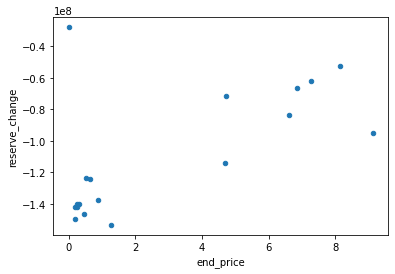

In [5]:
kpi_df.plot(kind='scatter',x='end_price',y='reserve_change')

When the end price is lower, meaning more price drop has happened due to panic sell, generally the reserve changes get more negative meaning more reserves are spent to "save the price".

Note in our simulation there's also cases where the end price is very low even if there's not much reserves spent due to early termination. This could be due to the capacity has been depleted (even though the reserve hasn't), so no more bidding is allowed from the RBS policy.

<AxesSubplot:xlabel='RBS_bid_total', ylabel='reserve_change'>

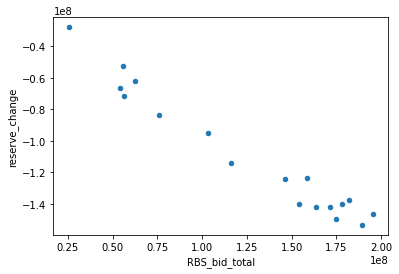

In [6]:
kpi_df.plot(kind='scatter',x='RBS_bid_total',y='reserve_change')

The total bid amount RBS spent negatively correlates with the total reserve change (more spent => less reserve in the end => more negative change), as expected.

# Comparing different RBS parameters in its effect of re-balancing panic selling

Here we are adjusting the `bid_factor` which is the ratio from reserve_stables that will be used for bidding when the price is too low.

Note: this may contradict to the deployed RBS where the bid_factor == ask_factor.

In [1]:
from model.utility.default_parameters import default_params1 as params
import pandas as pd
from model.signals.bond_signals import total_value_bond_creation
from model.utility.par_sweep import create_par_sweep
number_runs = 20
number_steps = 100


params.update({'panic_sell_on':[True]})

bid_factor = [0.095,0.2,0.4]
panic_params = [1,2,3]
sweep_dict = {'bid_factor':bid_factor,'panic_param':panic_params}
sweep_par_dict = create_par_sweep(sweep_dict)
params.update(sweep_par_dict)


In [30]:



from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run,new_run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
df2 = post_processing(raw)

df2.to_pickle('simudata/panic_sell_research/df2_rbs.p')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 180, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 180, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 770.04s


# analysis
questions:
- how do KPIs change with the RBS level

In [2]:
import pandas as pd
df2 = pd.read_pickle('simudata/panic_sell_research/df2_rbs.p')

In [3]:
from model.utility.par_sweep import add_sweep_par_to_df
df2_withpars = add_sweep_par_to_df(df2,sweep_par_dict) # prep the dataframe to add the sweeping parameters to notate each simulation

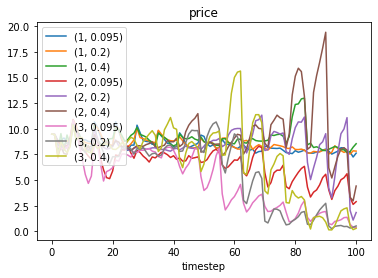

In [4]:
# Plot the average values for natural price by the groups of supply and demand factor
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

variables_to_plot = ["price"]
grouping_variables = ['panic_param','bid_factor']

fig = plot_grouped_variables_average(variables_to_plot,grouping_variables,df2_withpars,legend_loc='upper left')

From the price trend plot we found that when the panic sell is not too big (panic_param == 1), the price can be still in a relatively stable range.

When the panic sell is bigger (panic_param >=2), bigger the panic_param is, the price lunges lower. With more RBS capacity (higher bid_factor), there's a bigger change that the price can go up and panic sell will have a chance to calm down, but not guaranteed.

In [5]:
# Get KPIs
from model.utility.panic_sell_metrics import get_kpi_from_df
kpi_df = get_kpi_from_df(df2)

from model.utility.par_sweep import add_sweep_par_to_df
from scipy.stats import sem
import numpy as np
kpi_df_wpars = add_sweep_par_to_df(kpi_df,sweep_par_dict)
pars = list(sweep_dict.keys())



## pool drainage
This is the worst consequence of how panic sell could disrupt the market.

<AxesSubplot:title={'center':'pool_drained'}, xlabel='bid_factor,panic_param'>

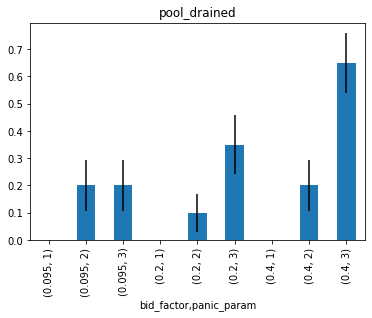

In [7]:
kpi = 'pool_drained'
kpi_stats = kpi_df_wpars[[kpi]+pars].groupby(pars).agg([np.mean,sem])
kpi_stats[kpi].plot(kind = "bar", y = "mean", legend = False, title = kpi, yerr = "sem")

Conclusion: Pool drainage is more tied to the higher panic sell pressure (panic_param being 2 or 3). Further more, it's worth noting that higher RBS bid_factor, bigger chance the pool will be drained especially with higher panic sell pressure, indicating that's not the most useful way to stop a panic sell.

## end price
This is another indicator of how the market is been disrupted by panic selling.

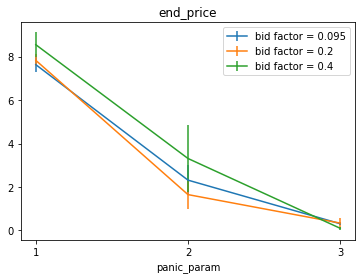

In [21]:
import matplotlib.pyplot as plt

kpi = 'end_price'
kpi_stats = kpi_df_wpars[[kpi]+pars].groupby(pars).agg([np.mean,sem])
fig,ax = plt.subplots()
for kk in bid_factor:
    kpi_stats[kpi].loc[kk].plot(kind = "line", y = "mean", ax=ax, legend = False, title = kpi, yerr = "sem")
ax.legend([f'bid factor = {k}' for k in bid_factor])
ticks = ax.set_xticks(panic_params)

Overall the end price is mostly determined by the panic sell level, as expected.

When the bid factor is higher (i.e. more resources RBS will use the recover the price), it can slightly increase the end price when the panic sell is not too bad (panic param <3)


## other impacts on the reserve

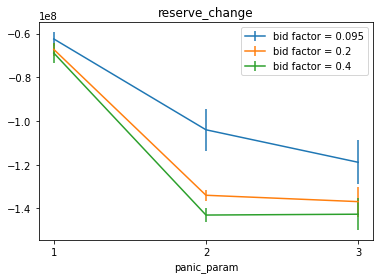

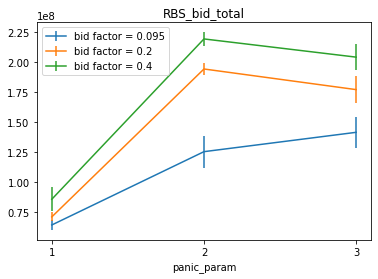

In [22]:
for kpi in ['reserve_change','RBS_bid_total']:
    kpi_stats = kpi_df_wpars[[kpi]+pars].groupby(pars).agg([np.mean,sem])
    fig,ax = plt.subplots()
    for kk in bid_factor:
        kpi_stats[kpi].loc[kk].plot(kind = "line", y = "mean", ax=ax,title = kpi, yerr = "sem")
    ax.legend([f'bid factor = {k}' for k in bid_factor])
    ticks = ax.set_xticks(panic_params)


The two analyses are corraborating the same idea: when bid factor is not very high, the more panic sell happens, the more amount of reserves the olympus treasure will need to spend to combat that price drop. When the bid factor is higher, however, the reserve changes will be bigger but will plateu as the panic_param gets bigger, potentially due to it's draining the whole reserve.

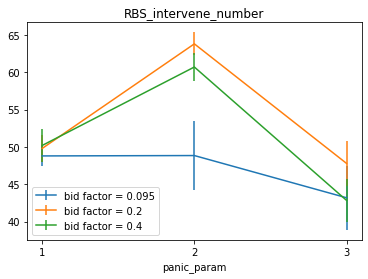

In [20]:
kpi = 'RBS_intervene_number'
kpi_stats = kpi_df_wpars[[kpi]+pars].groupby(pars).agg([np.mean,sem])
fig,ax = plt.subplots()
for kk in bid_factor:
    kpi_stats[kpi].loc[kk].plot(kind = "line", y = "mean", ax=ax, legend = False, title = kpi, yerr = "sem")
ax.legend([f'bid factor = {k}' for k in bid_factor])
ticks = ax.set_xticks(panic_params)

the number of RBS intervening drops when the panic_param is too high, likely due to the early termination of simulations because the pool has been drained.

## Overall conclusion
By varying the `panic_param` to adjust the level of panic selling, and `bid_factor` to adjust the level of RBS involvement, we found it's not always useful to simply increase the RBS bid_factor to combat the panic sell. When the panic sell is too big it can still drain the pool, so other non-RBS methods may need to be considered too. And even if only considering changing RBS policy, other factors such as shorter reinstate windows may also be considered in addition to changing the bid_factor.

### Future research recommendations
- Varying other RBS parameters (e.g. resinstate window length, cushion ratio...)
- Varying the set up of panic sell (e.g. probabilistic triggering of panic sell being on, different curves for characterizing panic sell amount...)
- Potentially adding more drastic approaches to combat panic selling other than RBS